In [1]:
import os
import copy

from collections import OrderedDict

import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.notebook import tqdm

from dal_toolbox.models.deterministic.simclr import SimCLR
from dal_toolbox.models.deterministic import resnet

plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0

<Figure size 640x480 with 0 Axes>

In [2]:
# Location of pretrained SimCLR Model
pretrained_filename = "pretrained_models/simclr_final_model.pth"


# Location of trained ResNet18
pretrained_filename_2 = "pretrained_models/resnet18_final_model.pth"

In [3]:
class ResNet18L(L.LightningModule):
    def __init__(self, num_classes, lr, weight_decay, n_epochs, momentum=0.9, nesterov=True):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet.ResNet18(num_classes=num_classes)
        self.ce_loss = nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay, momentum=self.hparams.momentum, nesterov=self.hparams.nesterov)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.n_epochs)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        x, y = batch
        out = self.model(x)
        loss = self.ce_loss(out, y)
        acc1 = torch.sum(out.softmax(-1).argmax(-1) == y) / y.shape[0]

        self.log(mode + "/loss", loss.item(), sync_dist=True)
        self.log(mode + "/acc1", acc1.item(), sync_dist=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

    def on_train_epoch_end(self) -> None:
        logging.info("Current Performance-Metric-Values:")
        for metr, val in self.trainer.logged_metrics.items():
            logging.info(metr+" : "+str(round(val.item(), 5)))
        return super().on_train_epoch_end()

In [4]:
class LogisticRegression(L.LightningModule):
    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[int(self.hparams.max_epochs * 0.6), int(self.hparams.max_epochs * 0.8)], gamma=0.1
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [5]:
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.262))])

train_img_data = CIFAR10(root='../../data', train=True, download=True, transform=img_transforms)
test_img_data = CIFAR10(root='../../data', train=False, download=True, transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000


In [6]:
@torch.no_grad()
def prepare_data_features(model, dataset, device):
    # Prepare model
    network = copy.deepcopy(model.model)
    network.linear = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=4, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

In [7]:
simclr_model = SimCLR(128, 5e-4, 0.07, 1e-4, 500)
simclr_state = torch.load(pretrained_filename)
simclr_state_adapt = OrderedDict()
for key, val in simclr_state.items():
    if "convnet" in key:
        new_key = 'model'
        for x in key.split(".")[1:]:
            if x == 'fc':
                x = 'linear'
            new_key += "." + x
        simclr_state_adapt[new_key] = val
    else:
        simclr_state_adapt[key] = val
simclr_model.load_state_dict(simclr_state_adapt)

train_feats_simclr = prepare_data_features(simclr_model, train_img_data, device='cuda')
test_feats_simclr = prepare_data_features(simclr_model, test_img_data, device='cuda')

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

In [8]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = L.Trainer(
        default_root_dir=os.path.join('./checkpoints', "LogisticRegression"),
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        log_every_n_steps=32,
        check_val_every_n_epoch=10,
        enable_progress_bar=False
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0
    )
    test_loader = data.DataLoader(
        test_feats_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0
    )


    L.seed_everything(42)  # To be reproducable
    model = LogisticRegression(**kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [9]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *(t.unflatten(0, (10, 5000))[:, :num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors)
    )
    return new_dataset

In [10]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500, 1000, 2500, 5000]:
    print("#########################################################################")
    print("num_imgs_per_label :=",num_imgs_per_label)
    print("#########################################################################")
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=num_imgs_per_label,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=10,
        lr=1e-3,
        weight_decay=1e-3,
    )
    results[num_imgs_per_label] = small_set_results

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
Missing logger folder: checkpoints/LogisticRegression/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


#########################################################################
num_imgs_per_label := 10
#########################################################################


/home/phahn/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/phahn/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/phahn/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (2) i

#########################################################################
num_imgs_per_label := 20
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
/home/phahn/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=32). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


#########################################################################
num_imgs_per_label := 50
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)
/home/phahn/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=32). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


#########################################################################
num_imgs_per_label := 100
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


#########################################################################
num_imgs_per_label := 200
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


#########################################################################
num_imgs_per_label := 500
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


#########################################################################
num_imgs_per_label := 1000
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


#########################################################################
num_imgs_per_label := 2500
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 5.1 K 
---------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.021     Total estimated model params size (MB)


#########################################################################
num_imgs_per_label := 5000
#########################################################################


`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


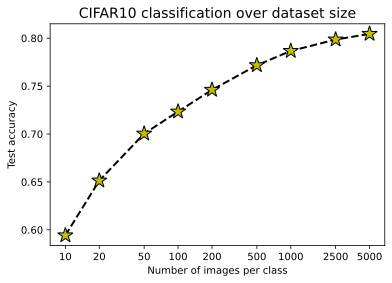

Test accuracy for  10 images per label: 59.42%
Test accuracy for  20 images per label: 65.14%
Test accuracy for  50 images per label: 70.04%
Test accuracy for 100 images per label: 72.34%
Test accuracy for 200 images per label: 74.61%
Test accuracy for 500 images per label: 77.18%
Test accuracy for 1000 images per label: 78.67%
Test accuracy for 2500 images per label: 79.86%
Test accuracy for 5000 images per label: 80.45%


In [11]:
dataset_sizes = sorted(k for k in results)
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("CIFAR10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

In [15]:
# Baseline
baseline = ResNet18L(10, 1e-1, 5e-4, 200)
baseline_state = torch.load(pretrained_filename_2)
baseline_state_adapt = OrderedDict()
for key, val in baseline_state.items():
    new_key = key.replace('fc', 'linear')
    baseline_state_adapt[new_key] = val
baseline.load_state_dict(baseline_state_adapt)

trainer_2 = L.Trainer(
    default_root_dir=os.path.join("./checkpoints/", "ResNet"),
    accelerator="auto",
    devices=1,
    max_epochs=200,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
        LearningRateMonitor("epoch"),
    ],
    check_val_every_n_epoch=2,
)
test_loader = data.DataLoader(test_img_data, batch_size=128, shuffle=False)
resnet_result = trainer_2.test(baseline, dataloaders=test_loader, verbose=False)

print(resnet_result)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: checkpoints/ResNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/phahn/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{'test/loss': 0.4258238673210144, 'test/acc1': 0.9089999794960022}]
